In [4]:
import os
import re
import sys
import json
import config
import random
import pickle
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from scipy.spatial.distance import cdist
from sklearn.dummy import DummyRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from IPython.display import SVG, display, Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble._forest import RandomForestRegressor
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN, OPTICS, Birch, KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score, pairwise_distances, davies_bouldin_score, calinski_harabasz_score


# warnings.filterwarnings("ignore")

In [5]:
# Credentials
os.environ["SPOTIPY_CLIENT_ID"] = config.SPOTIPY_CLIENT_ID
os.environ["SPOTIPY_CLIENT_SECRET"] = config.SPOTIPY_CLIENT_SECRET
os.environ['SPOTIPY_REDIRECT_URI'] = config.SPOTIPY_REDIRECT_URI  # Needed for user authorization

# Defining scope to read user playlist and write playlist to user
scope = 'user-library-read user-follow-read playlist-modify-private playlist-modify'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [18]:
# Change the path to where your Spotify Million Playlist is located.
# The expected file structure is to have a data folder /data .csv files will be placed there.

path = 'data/spotify_million_playlist_dataset/data'

def loop_slices(path, num_slices=20):
    """
    Each slice is a .json file containing 1000 playlists i.e.: 1 slice is 1000 playlists 20 slices is: 20,000 playlists.
    Parameters:
        num_slices (int): Number of slices to return, max 1000.
        path (str): Path to the Spotify Million Playlist.
        
    Output:
        mpd_playlists (list): a list of dictionaries of all the playlists.
    """
    cnt=0
    mpd_playlists = []
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        cnt+=1
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)
            
            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)


            if cnt == num_slices:
                break
    return mpd_playlists

In [19]:
playlists = loop_slices(path, num_slices=20)

mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json


In [26]:
with open('data/playlists.json', 'w') as outfile:
    json.dump(playlists, outfile, indent=2)

In [8]:
df = pd.read_csv('data/Playlist_Feats.csv')
df

name     pid  danceability    energy       key  loudness  \
0            Throwbacks       0      0.664077  0.781077  5.038462 -4.891212   
1      Awesome Playlist       1      0.492382  0.695923  4.461538 -8.107974   
2               korean        2      0.671062  0.692953  5.000000 -4.875594   
3                   mat       3      0.514349  0.620901  5.103175 -9.618754   
4                   90s       4      0.576235  0.650418  3.352941 -7.634529   
...                 ...     ...           ...       ...       ...       ...   
19995         gang gang  115995      0.804615  0.529026  4.205128 -8.164179   
19996             Chaos  115996      0.688900  0.695500  5.700000 -8.232650   
19997       Spring 2014  115997      0.646571  0.603214  5.357143 -6.890929   
19998            autumn  115998      0.549943  0.562457  5.114286 -8.666057   
19999             ChIlL  115999      0.680809  0.576838  5.139706 -6.657647   

           mode  speechiness  acousticness  instrumentalness  liveness  \
0      0.692308     0.103698      0.083674          0.000674  0.187087   
1      0.538462     0.091010      0.162227          0.223708  0.179344   
2      0.515625     0.096425      0.269100          0.000638  0.168894   
3      0.714286     0.067004      0.273514          0.203148  0.188278   
4      0.823529     0.041218      0.177189          0.081759  0.166524   
...         ...          ...           ...               ...       ...   
19995  0.589744     0.219638      0.217947          0.008621  0.166574   
19996  0.400000     0.104215      0.243258          0.225892  0.151770   
19997  0.714286     0.078743      0.227477          0.024347  0.146629   
19998  0.657143     0.065520      0.273361          0.018066  0.161580   
19999  0.625000     0.121825      0.258820          0.002936  0.146857   

        valence       tempo    duration_ms  time_signature  
0      0.642750  121.157500  221777.461538        4.000000  
1      0.476667  124.987128  298837.641026        3.769231  
2      0.565078  114.595984  219373.953125        4.000000  
3      0.451258  125.523048  229575.055556        3.952381  
4      0.490294  127.725412  255014.352941        3.941176  
...         ...         ...            ...             ...  
19995  0.363818  129.452256  230348.358974        4.000000  
19996  0.717800  135.314300  283091.000000        4.050000  
19997  0.442571  125.139071  268988.928571        4.000000  
19998  0.390406  114.144886  237814.542857        3.971429  
19999  0.456876  116.815824  228286.132353        3.963235  

[20000 rows x 15 columns]

In [10]:
# Read user favorite playlist
fav_songs_feats_df = pd.read_csv('data/fav_songs_feats_df.csv')
fav_songs_feats_df.head()

song           artist                     uri  \
0  Bendita Diabla - Apaga La Luz           E-Lhoy  0OxR238zEmOy20sSBbHgyK   
1  Sinnerman - Sofi Tukker Remix      Nina Simone  6Au1l0egQFYxbnCZxakoOL   
2             Lied vom Scheitern        Die Ärzte  3PUryKL6Jme3BlX95tutYn   
3                          Junge        Die Ärzte  10waMsh44ojvTwXAIy213n   
4              Müssen nur wollen  Wir Sind Helden  1e79l5iRNvf4q9YXjt1Mn8   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.714   0.535    1    -7.149     0       0.0549       0.54500   
1         0.795   0.764   11    -7.463     0       0.0400       0.41100   
2         0.523   0.971    3    -4.683     1       0.0988       0.00313   
3         0.563   0.792   10    -4.885     0       0.0350       0.05320   
4         0.706   0.672    4    -3.903     1       0.0296       0.11300   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000000    0.0859    0.619  130.045  audio_features   
1          0.010500    0.0912    0.156  124.027  audio_features   
2          0.000002    0.3800    0.381  144.956  audio_features   
3          0.000003    0.1070    0.176  105.463  audio_features   
4          0.000000    0.1670    0.829  125.941  audio_features   

                       id                                         track_href  \
0  0OxR238zEmOy20sSBbHgyK  https://api.spotify.com/v1/tracks/0OxR238zEmOy...   
1  6Au1l0egQFYxbnCZxakoOL  https://api.spotify.com/v1/tracks/6Au1l0egQFYx...   
2  3PUryKL6Jme3BlX95tutYn  https://api.spotify.com/v1/tracks/3PUryKL6Jme3...   
3  10waMsh44ojvTwXAIy213n  https://api.spotify.com/v1/tracks/10waMsh44ojv...   
4  1e79l5iRNvf4q9YXjt1Mn8  https://api.spotify.com/v1/tracks/1e79l5iRNvf4...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/0OxR...       210000   
1  https://api.spotify.com/v1/audio-analysis/6Au1...       232632   
2  https://api.spotify.com/v1/audio-analysis/3PUr...       209187   
3  https://api.spotify.com/v1/audio-analysis/10wa...       187533   
4  https://api.spotify.com/v1/audio-analysis/1e79...       215747   

   time_signature  
0               4  
1               4  
2               4  
3               4  
4               4

In [11]:
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# The Data

For this project we are using The Million Playist Dataset, as it name implies,the dataset consists of one million playlists and each playlists contains n number of songs and some metadata is included as well such as name of the playlist, duration, number of songs, number of artists, etc.

It is created by sampling playlists from the billions of playlists that Spotify users have created over the years. Playlists that meet the following criteria were selected at random:

 * Created by a user that resides in the United States and is at least 13 years old
 * Was a public playlist at the time the MPD was generated
 * Contains at least 5 tracks
 * Contains no more than 250 tracks
 * Contains at least 3 unique artists
 * Contains at least 2 unique albums
 * Has no local tracks (local tracks are non-Spotify tracks that a user has on their local device)
 * Has at least one follower (not including the creator)
 * Was created after January 1, 2010 and before December 1, 2017
 * Does not have an offensive title
 * Does not have an adult-oriented title if the playlist was created by a user under 18 years of age
 
As you can imagine a million anything is too large to handle and we are going to be using 2% of the data (20,000 playlists) to create the models and the scaling to an AWS instance.
 
## Enhancing the data
Since this dataset is released by Spotify, it already includes a track id that can be used to generate API calls and access the multiple information that is provided from Spotify for a given song, artist or user.

These are some of the features that are available to us for each song and we are going to use them to enhance our dataset and to help matching the user's favorite playlist.

Some of the available features are the following, they are measured mostly in a scale of 0-1:
 - Danceability: a measurement of how "danceable" a given song is.
 - Energy: perceptual measure of intensity and activity.
 - Intrumentalness: whether a song contains no vocals (pure instrumental).
 - Liveness: presence of audience in a song i.e.: on a concert.
 - Loudness: How loud a song is in dB.
 - Mode: Minor or Major mode.
 - Speechiness: presence of words in a song.
 - Tempo: Beats per minute (BPM)
 
## Shapping the data
The 20,000 playlists were parsed through the Spotify API to retrieve the audio features for each son in each playlist, this in itself is a very time consuming operation due to the latency of the API calls, to give you an idea, 40 hours were needed to collect the features for all songs in each playlist.

Once the features were collected, the average of them were taken to have the audio features for the playlist with this, we reduced the dataset to a single row per playlist with a good feature representation of the contents of them.


# Supervised Approach
One of the first things we did was to explore a supervised method but that did not turned out well because of the data we collected does not have any labels, yes, it is true that each playlist has a label in the form of a playlist name but the target songs that we are using are the user's favorite songs which is nothing but a big playlist of songs that the user has liked in the past and it is not labeled in any way. Because of this, we found out really soon that a supervised method was outside of our hands.

One thing that can be done in the future is to read the user's self created playlists or liked playlist and use the names of those playlists and then create a supervised learning model.

In [ ]:
df.T

In [ ]:
# Transpose df to have playlists as features - This is going to be X
X = df[feat_cols].set_index('pid').T
# Mean of the features of the user's fav songs - This is going to be y
y = fav_songs_feats_df[feat_cols_user].mean()

# Split data for training and testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

In [ ]:
# Dummy classifiers to check against real classifier
dummy_A = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
dummy_B = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_dummy_A_predictions = dummy_A.predict(X_test)
y_dummy_B_predictions = dummy_B.predict(X_test)

R2_A = dummy_A.score(X_test, y_test)
RMSE_A = mean_squared_error(y_test, y_dummy_A_predictions, squared=False)
MAE_A = mean_absolute_error(y_test, y_dummy_A_predictions)

R2_B = dummy_A.score(X_test, y_test)
RMSE_B = mean_squared_error(y_test, y_dummy_B_predictions, squared=False)
MAE_B = mean_absolute_error(y_test, y_dummy_A_predictions)

print('Dummy Regressor A Scores (Mean)')
print('R2: {}'.format(R2_A))
print('RMSE:    {}'.format(RMSE_A))
print('MAE:  {}\n'.format(MAE_A))

print('Dummy Regressor B Scores (Median)')
print('R2: {}'.format(R2_B))
print('RMSE:    {}'.format(RMSE_B))
print('MAE:  {}'.format(MAE_B))

In [ ]:
models = [LinearRegression(), Lasso()]

In [ ]:
reg = LinearRegression().fit(X, y)
print(reg)
print('R2: {}'.format((reg.score(X, y))))
y_pred = reg.predict(X)
print('RMSE: {}'.format(mean_squared_error(y, y_pred, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y, y_pred)))

importance = reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
# Can combine step above with this
forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
forest.fit(X,y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[indices[f]]))

# Unsupervised Approach

In [22]:
df.head()

name  pid  danceability    energy       key  loudness  \
0        Throwbacks    0      0.664077  0.781077  5.038462 -4.891212   
1  Awesome Playlist    1      0.492382  0.695923  4.461538 -8.107974   
2           korean     2      0.671063  0.692953  5.000000 -4.875594   
3               mat    3      0.514429  0.620902  5.103175 -9.618754   
4               90s    4      0.576235  0.650418  3.352941 -7.634529   

       mode  speechiness  acousticness  instrumentalness  liveness   valence  \
0  0.692308     0.103698      0.083674          0.000674  0.187087  0.642750   
1  0.538462     0.091010      0.162227          0.223708  0.179344  0.476667   
2  0.515625     0.096425      0.269100          0.000638  0.168894  0.565078   
3  0.714286     0.067000      0.273514          0.203156  0.188278  0.451258   
4  0.823529     0.041218      0.177189          0.081759  0.166524  0.490294   

        tempo    duration_ms  time_signature  
0  121.157500  221777.461538        4.000000  
1  124.987128  298837.641026        3.769231  
2  114.595984  219373.953125        4.000000  
3  125.547627  229575.055556        3.952381  
4  127.725412  255014.352941        3.941176

In [12]:
# feats_df = df[feat_cols_user]
y = fav_songs_feats_df[feat_cols_user].mean()
scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
feats_df = pd.DataFrame(scaled_data)
feats_df.head()

0         1         2         3         4         5         6   \
0  0.612856  1.087184 -0.201775  0.996660  0.208011  0.192259 -0.913576   
1 -1.181611  0.440106 -1.061919 -0.305130 -0.779607 -0.032644 -0.456511   
2  0.685865  0.417537 -0.259118  1.002980 -0.926207  0.063337  0.165333   
3 -0.952022 -0.129984 -0.105293 -0.916527  0.349099 -0.458178  0.191017   
4 -0.305220  0.094313 -2.714744 -0.113532  1.050391 -0.915264 -0.369455   

         7         8         9         10        11        12  
0 -0.473002 -0.007089  1.210086 -0.020760 -0.385630  0.590494  
1  1.291821 -0.187318 -0.100881  0.497542  1.926104 -1.768360  
2 -0.473291 -0.430553  0.596989 -0.908796 -0.457733  0.590494  
3  1.129130  0.020639 -0.301443  0.570073 -0.151709  0.103746  
4  0.168603 -0.485723  0.006686  0.868141  0.611446 -0.010782

In [24]:
# Save model and scaled_data locally
filename = 'models/StdScaler.sav'
pickle.dump(scaler, open(filename, 'wb'))
np.savetxt('data/scaled_data.csv', scaled_data, delimiter=',')

In [13]:
%%time
# Getting TSNE with openTSNE
tsne = openTSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=-1,
    random_state=0,
    verbose=False,
)

tsne_transformer = tsne.fit(scaled_data)
df_opentsne = pd.DataFrame(tsne_transformer.transform(scaled_data),columns=['X','Y']) 
df_opentsne

CPU times: user 1min 47s, sys: 10.4 s, total: 1min 58s
Wall time: 2min 9s


X          Y
0     -30.645349  -3.908719
1      13.480551  -0.775494
2     -25.230878   9.993515
3      11.322158  -1.857894
4      12.167744 -13.662932
...          ...        ...
19995 -21.419862  61.122494
19996  14.491667  22.605771
19997  -2.853510   6.915464
19998  21.213676  11.172959
19999 -13.686224  31.831885

[20000 rows x 2 columns]

In [31]:
# Save model locally
filename = 'models/openTSNETransformer.sav'
pickle.dump(tsne_transformer, open(filename, 'wb'))

In [14]:
sns.scatterplot(x='X', y='Y', data=df_opentsne, legend=None)

<AxesSubplot:xlabel='X', ylabel='Y'>

In [33]:
# Save Model Locally
df_opentsne.to_csv('data/df_openTSNE.csv', index=False)

In [15]:
def single_model_and_plot(model, K, df, df_clusters, title, random_state=0):
    try:
        clustering = model(n_clusters=K, random_state=random_state).fit(df)
    except TypeError:
        clustering = model(n_clusters=K).fit(df)
    df_clusters['cluster'] = pd.Categorical(clustering.labels_)
    
    fig = plt.figure(figsize=(20,20))
    
    plt.subplot(2,2,1)
    sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_clusters, legend=None)


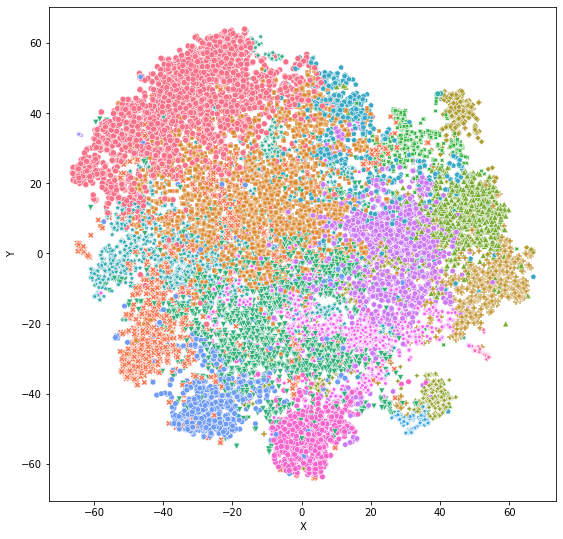

In [16]:
single_model_and_plot(AgglomerativeClustering, K=20, df=scaled_data, df_clusters=df_opentsne, 
                      title='Clustering on scaled data', random_state=None)

## Evaluation
We are going to use 7 different clustering models to evaluate the cluster perfomarmance with 3 different score metrics. 
There are 2 groups of clusters, one is those that don't have a number of cluster parameters and the other that does.

Models without K number of clusters as parameter:
- Affinity Propagation
- DBSCAN
- OPTICS

Models with K nummber of clusters as parameter:
- KMeans
- Birch
- Agglomerative
- Gaussian Mixture
- Spectral Clustering

For the latter, we are going to fit a model with k=2 to k=100 and score the clusters with the 3 differen metrics that are: Silhouette, Davis-Bouldin and Calinski-Harabasz.

In [ ]:
def models_without_k_scoring(data):
    """
    The models for this function are those models where there is no K number of cluster declaration such as Affinity Propagation,
    DBSCAN, OPTICS, etc.
    
    This function fits the input models to the input data and saves the models in a pickle form for later use due to 
    some of them will take hours to run.
    
    Silhouette, Davies-Bouldin and Calinski-Harabasz are calculated and output to a dictionary
    Models are saved to a /models folder, you need to create the folder in case you don't have it already.
    
    Parameters:
        - models (list): a list of tuples where each tuple is of the form ('model', model)
        - data (df): a dataframe with the scaled data
    Return:
        - dict_scores (dictionary): a dictionary with the scores processed
        - models (pickle): pickle models saved directly to your hard drive inside /models
    """
    models = [('AffinityPropagation', AffinityPropagation), ('DBSCAN', DBSCAN), ('OPTICS', OPTICS)]
    
    silhouette = []
    davies = []
    calinski = []
    dict_scores = {}
    
    for idx, model in enumerate(tqdm(models)):
        print(model[0])
        
        try:
            clstr = model[1](random_state=0).fit(data)
            labels = clstr.labels_
        except:
            clstr = model[1]().fit(data)
            labels = clstr.labels_   
        
        filename = 'models/{}_model.sav'.format(model[0])
        pickle.dump(clstr, open(filename, 'wb'))
        
        silhouette.append(silhouette_score(data, labels))
        davies.append(davies_bouldin_score(data, labels))
        calinski.append(calinski_harabasz_score(data, labels))
        
        dict_scores[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
    
    with open('data/models_wo_k_scores.json', 'w') as outfile:
        json.dump(dict_scores, outfile, indent=2)
    
    return dict_scores

In [15]:
filename = 'AffinityPropagation_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_opentsne['cluster'] = pd.Categorical(loaded_model.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)

<AxesSubplot:xlabel='X', ylabel='Y'>

<AxesSubplot:xlabel='X', ylabel='Y'>

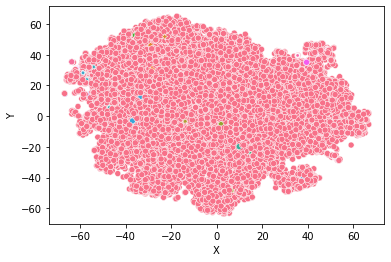

In [18]:
filename = 'OPTICS_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_opentsne['cluster'] = pd.Categorical(loaded_model.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)

In [19]:
filename = 'DBSCAN_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_opentsne['cluster'] = pd.Categorical(loaded_model.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)

<AxesSubplot:xlabel='X', ylabel='Y'>

[-1, 1, 0]
Categories (3, int64): [-1, 0, 1]

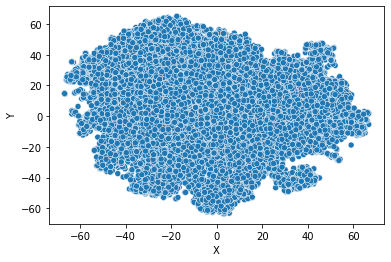

In [21]:
clstr = DBSCAN(metric='manhattan', eps=1).fit(feats_df)
df_opentsne['cluster'] = pd.Categorical(clstr.labels_)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
df_opentsne['cluster'].unique()

In [38]:
def model_evaluation(data, max_k=5):
    """
    The models for this function are those models where there is a K number of cluster declaration such as KMeans, Birch,
    AgglomerativeCluster, etc.
    
    This function fits the input models to the input data.
    
    Silhouette, Davies-Bouldin and Calinski-Harabasz are calculated and output to a dictionary
    
    Parameters:
        - models (list): a list of tuples where each tuple is of the form ('model', model).
        - data (df): a dataframe with the scaled data.
        - max_5 (int): max number of k clusters to run for each model.
    Return:
        - dict_scores (dictionary): a dictionary with the scores processed.
    """
    models = [('KMeans', KMeans), ('Birch', Birch), ('Agglomerative', AgglomerativeClustering), 
              ('GaussianMixture', GaussianMixture)]
    
    cluster_size = range(2, max_k+1)
    dict_scores = {}
    
    #Plot setup
    cols = 3
    rows = len(models)
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    
    for idx, model in enumerate(tqdm(models)):
        silhouette = []
        davies = []
        calinski = []
        print(model[0])
        
        for k in tqdm(cluster_size):
            if model[0] in ('KMeans', 'SpectralClustering'):
                clstr = model[1](n_clusters=k, random_state=0).fit(data)
                labels = clstr.labels_
                
            elif model[0] in ('Agglomerative', 'Birch'):
                clstr = model[1](n_clusters=k).fit(data)
                labels = clstr.labels_
                
            elif model[0]=='GaussianMixture':
                clstr = model[1](n_components=k).fit(data)
                labels = clstr.predict(data)
   
            silhouette.append(silhouette_score(data, labels))
            davies.append(davies_bouldin_score(data, labels))
            calinski.append(calinski_harabasz_score(data, labels))
            
        dict_scores[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
                   
        #Plot printing, each model in a row        
        i = 0
        j = idx
        plt.subplot(gs[j,i])
        plt.plot(cluster_size, silhouette, label='silhouette')
        plt.title(model[0]+' - Silhouette', fontsize=15)
        plt.xlabel("K", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        
        plt.subplot(gs[j,i+1])
        plt.plot(cluster_size, davies, label='davies')
        plt.title(model[0]+' - Davies-Bouldin', fontsize=15)
        plt.xlabel("K", fontsize=12)
        
        plt.subplot(gs[j,i+2])
        plt.plot(cluster_size, calinski, label='calinski')
        plt.title(model[0]+' - Calinski-Harabasz', fontsize=15)
        plt.xlabel("K", fontsize=12)
    
    with open('data/models_with_k_scores.json', 'w') as outfile:
        json.dump(dict_scores, outfile, indent=2)
    
    plt.tight_layout()
    plt.savefig("images/ClusteringScores.svg")
    plt.show()
            
    return dict_scores

In [ ]:
##################################################################################################################
# STOP                                                                                                           #
# These functions will take 2+ hours to run with a 32Gb memory do not run unless totally necessary.                #
#                                                                                                                #
# model_evaluation() - was run previously and results are stored in data/models_with_k_scores.json and           #
# ClusteringScores.svg                                                                                           # 
#                                                                                                                #
# models_without_k_scoring() - was run previously and results are stored in data/models_wo_k_scores.json and     #
# models are stored in models/ as a pickle object                                                                #
##################################################################################################################
model_evaluation(feats_df, max_k = 100)
models_without_k_scoring(feats_df)

## Scores
From the plot and results above a couple of things can be said:
- Affinity Propagation does not scale well and specially with the size of the data is not recommended to use plus the scores are not promissing.
- Spectral Clustering was not even tried due to iterating over 100 different fittings would've taken days and also that this is only with 2% of the data.
- Davies-Boulding seems to be the best way to score our data, the lowest the score the better the clustering.
- The best number of cluster is around 20.


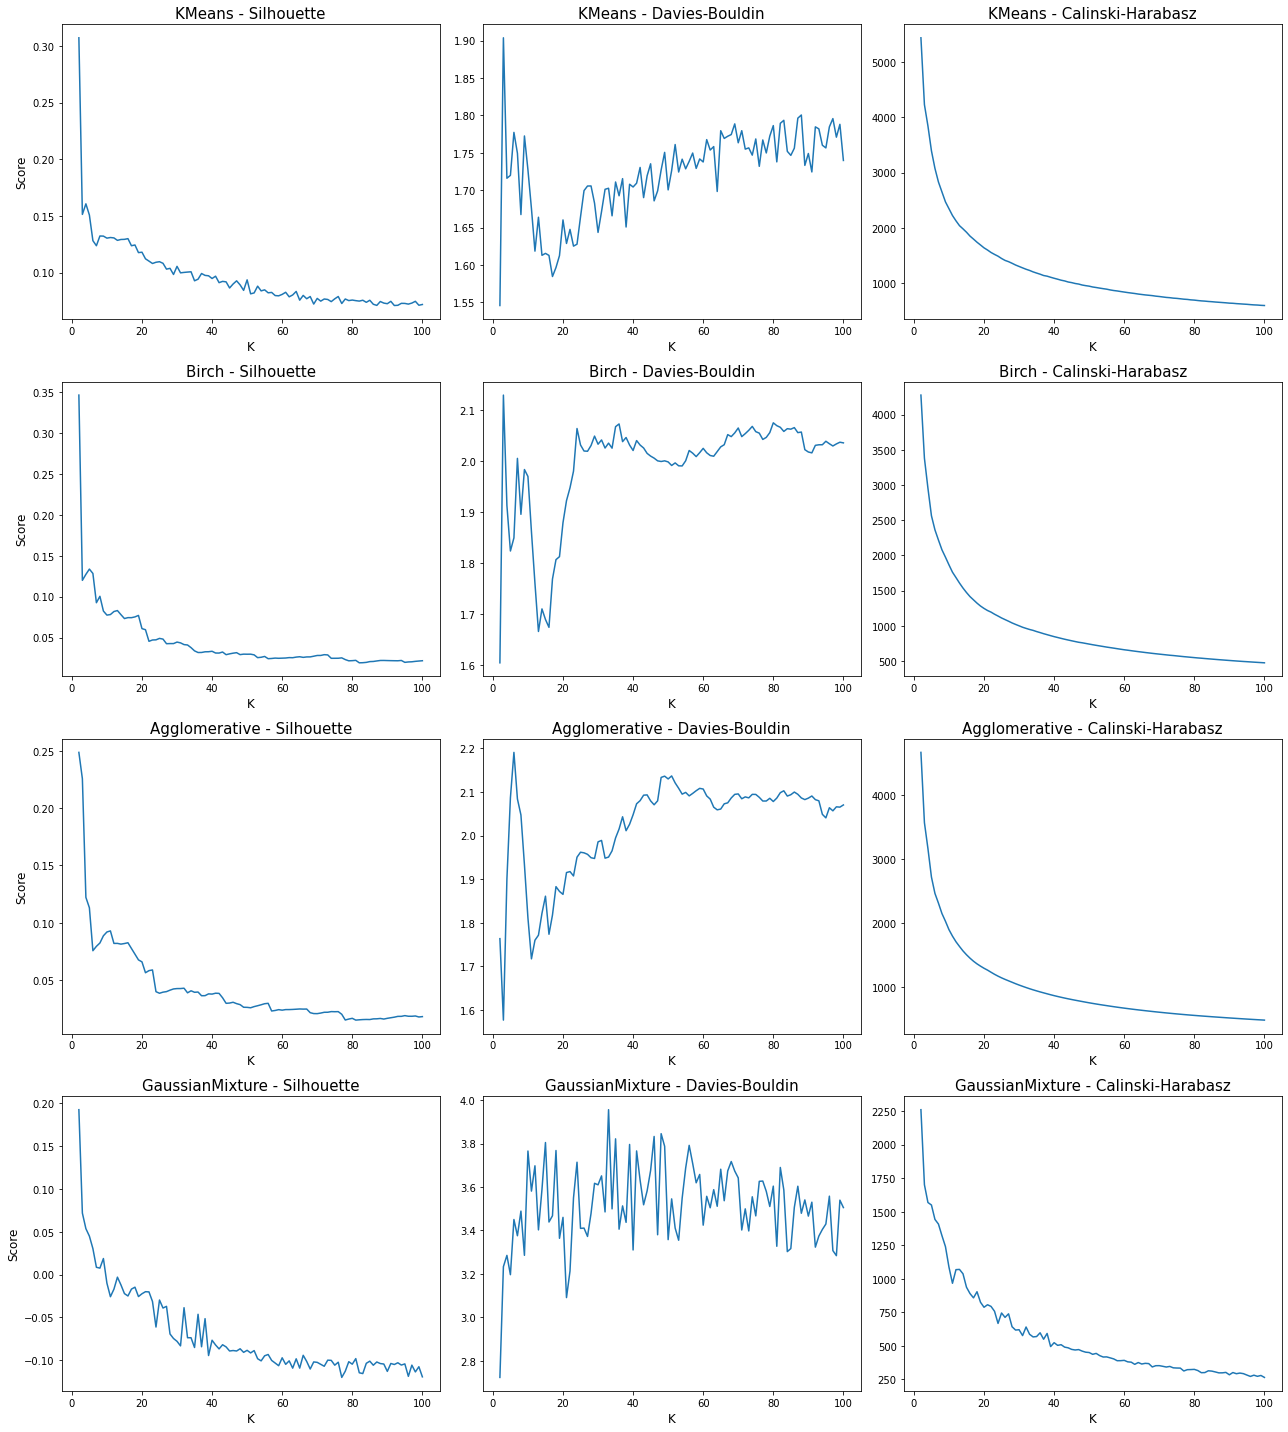

In [17]:
# Display scores plot from model_evaluation() function

# display(SVG(filename='images/ClusteringScores.svg')) # High def plot
Image(filename='images/ClusteringScores.png')

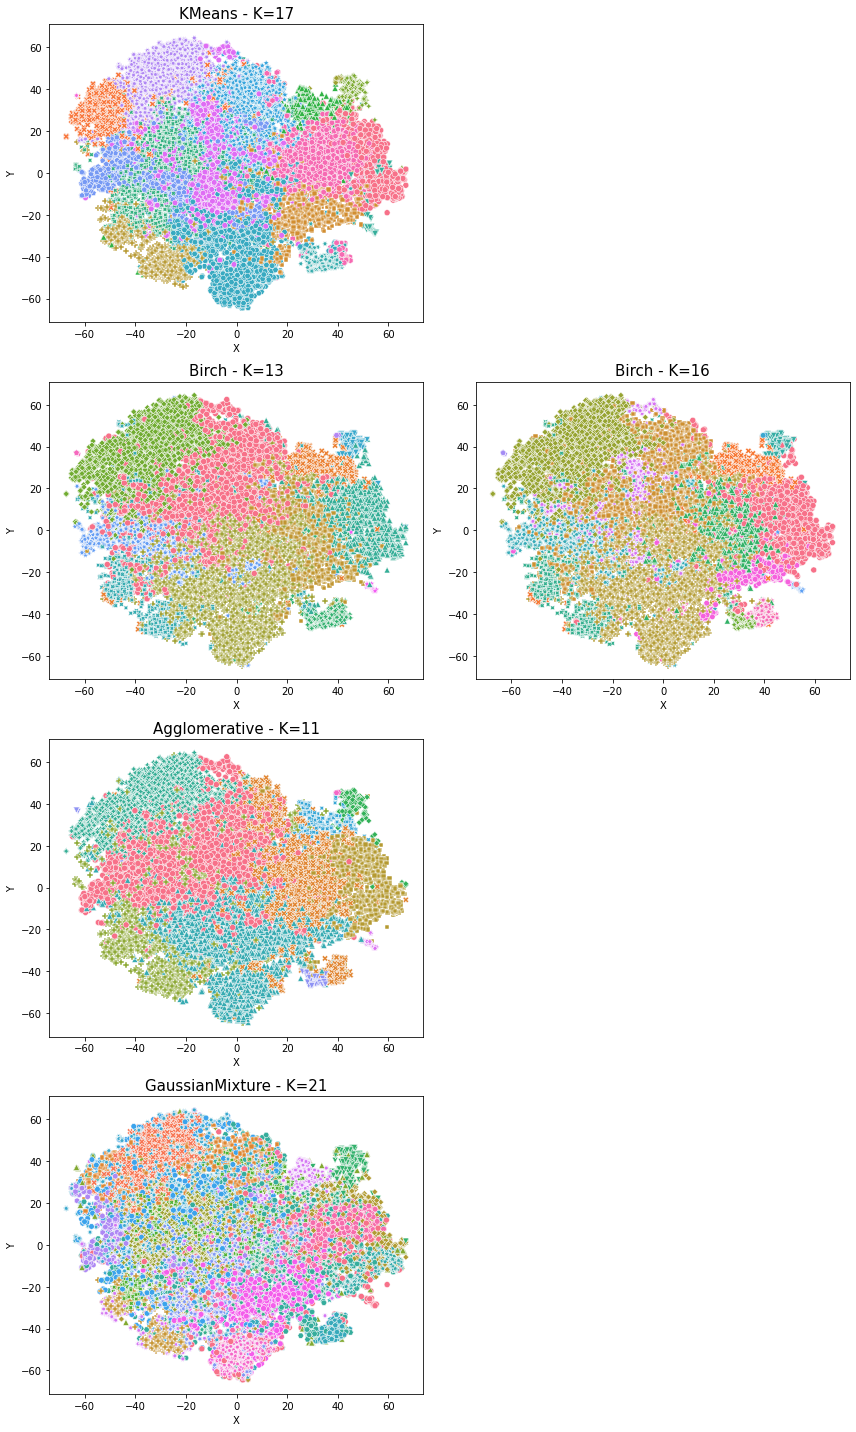

In [11]:
# Load scores from model_evaluation() function and extract the best K for each model based on Davies-Bouldin Score.
with open("data/models_with_k_scores.json", "r") as read_file:
    scores_dict = json.load(read_file)

# Extract lower Davies-Bouldin score for each model
KMeans_K = [np.asarray(scores_dict['KMeans']['davies']).argsort()[1]+2]
Birch_K = (np.asarray(scores_dict['Birch']['davies']).argsort()[1:3]+2).tolist()
Aglo_K = [np.asarray(scores_dict['Agglomerative']['davies']).argsort()[1]+2]
GausM_K = [np.asarray(scores_dict['GaussianMixture']['davies']).argsort()[1]+2]

models = [('KMeans', KMeans, KMeans_K), ('Birch', Birch, Birch_K), ('Agglomerative', AgglomerativeClustering, Aglo_K), 
          ('GaussianMixture', GaussianMixture, GausM_K)]

#Plot setup
cols = 2
rows = len(models)
y_size = 5*rows
fig = plt.figure(figsize=(12,y_size))
gs = plt.GridSpec(rows, cols)


# Fit and plot with best K
for idx, model in enumerate(models):
    i=0
    for k in model[2]:
        if model[0] in ('KMeans'):
            clstr = model[1](n_clusters=k, random_state=0).fit(feats_df)
            labels = clstr.labels_
                
        elif model[0] in ('Agglomerative', 'Birch'):
            clstr = model[1](n_clusters=k).fit(feats_df)
            labels = clstr.labels_
                
        elif model[0]=='GaussianMixture':
            clstr = model[1](n_components=k).fit(feats_df)
            labels = clstr.predict(feats_df)
        
        
        #Plot printing, each model in a row        
        
        j = idx
        plt.subplot(gs[j,i])
#         plt.plot(cluster_size, silhouette, label='silhouette')
        plt.title(model[0]+' - K={}'.format(k), fontsize=15)
#         plt.xlabel("K", fontsize=12)
#         plt.ylabel("Score", fontsize=12)
        
        df_opentsne['cluster'] = pd.Categorical(labels)
        sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
        
        i+=1
plt.tight_layout()
plt.savefig("images/ClusteringOnTSNE.svg")
plt.show()    

In [12]:
KMeans_s = np.sort(np.asarray(scores_dict['KMeans']['davies']))[1]
Birch_s = np.sort(np.asarray(scores_dict['Birch']['davies']))[1]
Agglo_s = np.sort(np.asarray(scores_dict['Agglomerative']['davies']))[1]
GM_s = np.sort(np.asarray(scores_dict['GaussianMixture']['davies']))[1]
round(KMeans_s, 2), round(Birch_s, 2), round(Agglo_s, 2), round(GM_s, 2)

(1.58, 1.67, 1.72, 3.09)

## Model Selection
From these results, it can be seen, by visual inspection, how KMeans is the best model to create clusters, it is fascinating how one of the simplest and more straight forward model is the best performer here, this is good for our analysis and for our type of data given the fact that it can scale well for the size of our data (1M playlists).

This does not come as a surprise due to KMeans has the lowest Davies-Bouldin Score among all models, let's remeber that this number represents the average similarity of each cluster with a cluster most similar to it. The lower the average similarity is, the better the clusters are separated and the better is the result of the clustering performed. [Reference: https://ieeexplore.ieee.org/document/4766909]

Davies-Bouldin Scores:

- KMeans: 1.58
- Birch: 1.67
- Agglomerative: 1.72
- Gaussian Mixture: 3.09

## Cluster exploration
After clustering the playlist names are stracted to explore what type of music is inside each cluster, from this exploration, these are the top 10 most common playlist names for each cluster.

AS it can be seen, there are strong differences between some cluster but other cluster are really similar to each other.

The model developed is so powerful that out of 20,000 playlists it was able to distinguish and separate those playlists that contains stand up comedy and even more surprising, there are only 8, yes 8 playlist in the whole data set. This is mind blowing!!!!!!!!!

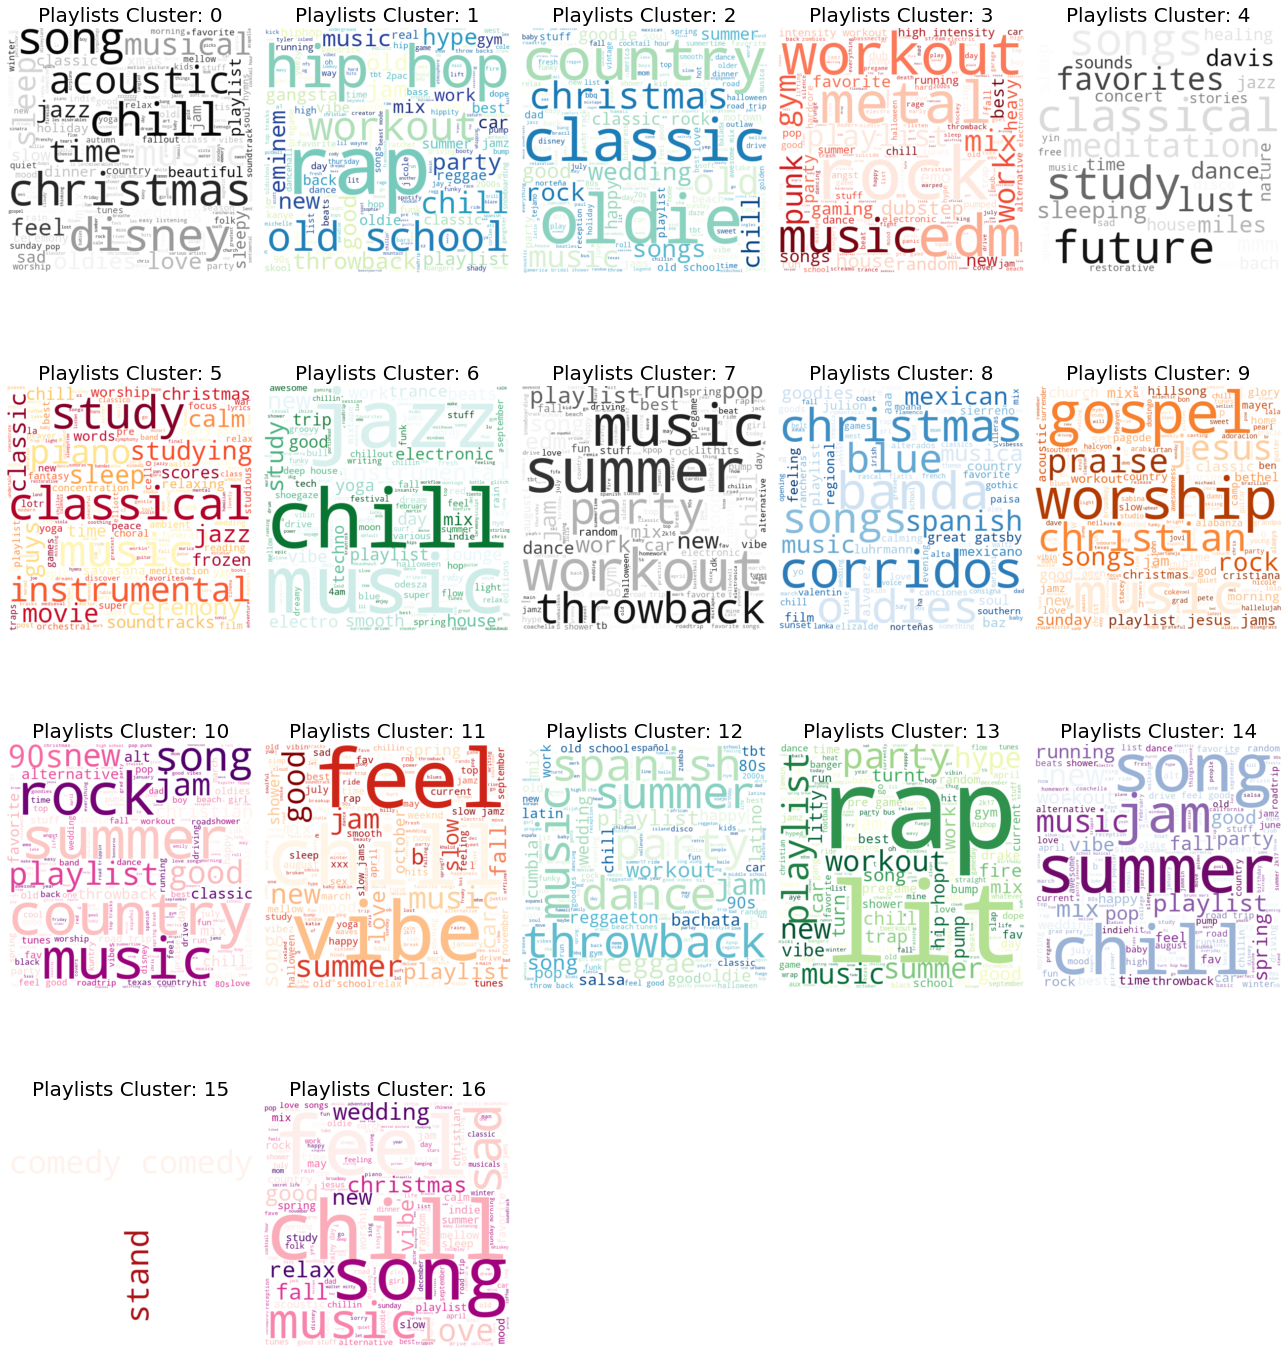

In [18]:
# Fit and pickle model. Uncomment to retrain
filename = 'models/KMeans_K17_20000_sample_model.sav'
# model = KMeans(n_clusters=17, random_state=0).fit(feats_df)
# pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))
top_playlists = []
# df_cluster = pd.DataFrame()

def cluster_exploration(model, df):
    df['name'] = df['name'].str.lower()
    df['cluster'] = pd.Categorical(model.labels_)
    categories = df['cluster'].cat.categories
    
    #Plot setup
    cols = 5
    rows = len(categories)//cols + len(categories)%cols
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    sequential =['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
             'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    
    for idx, category in enumerate(categories):
        color = random.choice(sequential)
        df_cat = df[df['cluster']==category]
        text = ' '.join(df_cat["name"])
        df_cat = (df_cat.groupby('name')
                             .agg(count=('pid', 'count'))
                             .reset_index().sort_values(by=['count'], ascending=False)
                             .head(10)
                             .reset_index(drop=True))
#         df_cat.columns = pd.MultiIndex.from_product([['Cluster {}'.format(category)], df_cat.columns])
        df_cat.rename({'name': 'Cluster {}'.format(category)}, axis=1, inplace=True)
        top_playlists.append(df_cat[['Cluster {}'.format(category)]])

        #Plot printing, each model in a row        
        i = idx%cols
        j = idx//cols
        plt.subplot(gs[j,i])
        wc = WordCloud(background_color ='white',relative_scaling=0, width=500, height=500, colormap=color).generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title('Playlists Cluster: {}'.format(category), size=20)
    plt.tight_layout()
    plt.savefig("images/WordCloudPerCluster.svg")
    plt.show()  
    return pd.concat(top_playlists, axis=1)
top_playlists_df = cluster_exploration(model, df)

In [14]:
top_playlists_df

Cluster 0   Cluster 1           Cluster 2                  Cluster 3  \
0  christmas         rap              oldies                       rock   
1     disney     workout            classics                        edm   
2   musicals     hip hop             country                    workout   
3      sleep      eminem           christmas                      metal   
4      chill  old school        classic rock                        gym   
5     oldies     hip-hop               chill                    dubstep   
6   acoustic   chill rap  oldies but goodies                      house   
7       jazz       party              motown                       punk   
8      feels   throwback          old school                     gaming   
9        sad       chill                rock  my high-intensity workout   

        Cluster 4     Cluster 5      Cluster 6   Cluster 7          Cluster 8  \
0       classical     classical          chill     workout           corridos   
1           study  instrumental           jazz       party              banda   
2            bach         study    smooth jazz       chill          christmas   
3     meditation          sleep  instrumentals   throwback             oldies   
4         stories   study music   instrumental         edm             musica   
5         special      studying         lounge         run            country   
6  sleeping songs         piano     deep house  throwbacks            spanish   
7      sleep time       classic      chill out         pop          corridos    
8       sad songs          calm         techno     running  regional mexicano   
9    restorative       savasana          beats      summer             banda    

       Cluster 9      Cluster 10   Cluster 11  Cluster 12 Cluster 13  \
0        worship         country        chill  throwbacks        rap   
1         gospel        country         feels   throwback        lit   
2      christian            rock        vibes     spanish    workout   
3  worship music    classic rock          r&b       party      party   
4     jesus jams           chill         2017      reggae       hype   
5       worship        road trip    slow jamz     workout      chill   
6          jesus  summer country  chill vibes   reggaeton      litty   
7  worship songs             alt       mellow       dance       trap   
8         praise            work       summer     bachata       fire   
9    jesus music          summer    slow jams      latino        new   

  Cluster 14 Cluster 15 Cluster 16  
0      chill     comedy      chill  
1    running   stand up      feels  
2     summer        NaN      relax  
3        new        NaN      study  
4       jams        NaN  christmas  
5      party        NaN      sleep  
6    workout        NaN         <3  
7       2017        NaN        sad  
8        pop        NaN   acoustic  
9  feel good        NaN       love

## Music Recommendation based on Clustering
After clustering our data and exploring the results, we found out that the clusters make sense and they are good quality clusters.

The music recommendation we are going to do is based on clustering, we know that each cluster has similar music in it and this is key part of our recommender system because each cluster will serve as a hard boundary and this allow us to play with all the information for a given cluster.

By having a hard boundary, we can leverage that to use different metrics and different distances without the risk of recommending music that it is unrelated to the user's music taste and also alliviating the issue of always recommending music that it is too similar to the user's taste.

The procedure for this recommender system is to gather the user's favorite songs and compute the mean features, with our previously trained model, we can now predict in which cluster our user is going to fall, based on this, we will use the playlists belonging to that specific cluster and compute similarity.

There are 6 different ways to recommend with this approach that will use 3 different similarity metrics (euclidean, manhattan and cosine) where for each metric the top n most similar playlist can be suggested to the user or the top n most "disimilar" playlists. With the approach of most disimilar, we can recommend playlists that are far from the user but still within the hard boundaries of the cluster.



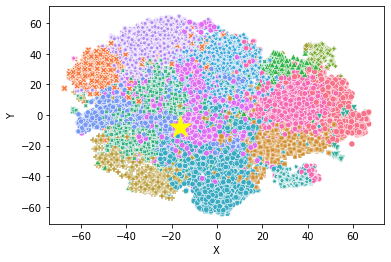

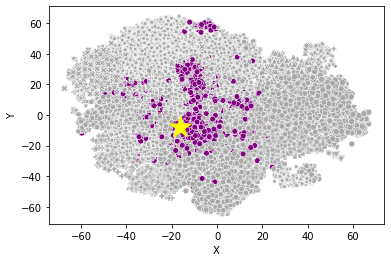

In [15]:
# Fit and pickle model. Uncomment to retrain
filename = 'models/KMeans_K17_20000_sample_model.sav'
# model = KMeans(n_clusters=17, random_state=0).fit(feats_df)
# pickle.dump(model, open(filename, 'wb'))

# Load model
model = pickle.load(open(filename, 'rb'))
df_opentsne['cluster'] = pd.Categorical(model.labels_)
df['cluster'] = pd.Categorical(model.labels_)


# Transform user fav songs to TSNE to plot in vector space
user_tsne = tsne_transformer.transform(scaled_y)[0]

user_cluster = model.predict(scaled_y)


sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500)
plt.show()

palette = {c:'purple' if c==user_cluster else 'darkgrey' for c in df.cluster.unique()}
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None, palette=palette)
plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500)
plt.show()

In [16]:
def get_top_n_playlists(model, feats_df, playlists, y, n, metric, similar, printing):
    """
    This function will compute the most similar or disimilar playlists given a target vector y which represents the mean
    features of the user's favorite songs. Similarity is calculated based on metrics such as Cosine, Manhattan, Euclidean, etc.
    Parameters:
        - model: Trained clustering model.
        - feats_df (dataframe): Dataframe with scaled data for all the training data
        - playlists (dictionary): Dictionary with all the playlists from the .json files
        - y (np.array): user's favorite songs scaled vector
        - n (int): top n playlists to retrieve
        - metric (str): metric to use, recommended 'cityblock', 'euclidean', 'cosine'.
        - similar (bool): whether to calculate most similar or most disimilar 
        - printing (bool): whether to print the results or not
    Output:
        - indices (np.array): indices of the top n playlists based on the feats_df dataframe
    
    """
    feats_df['cluster'] = pd.Categorical(model.labels_)
    user_cluster = model.predict(y)
    
    df_slice = feats_df[feats_df['cluster']==user_cluster[0]]
    df_slice = df_slice.drop(['cluster'], axis=1)
    indices = feats_df[feats_df['cluster']==user_cluster[0]].reset_index()['index'].to_numpy()
    
    scaled_data = df_slice.to_numpy()
    if similar:
        simi = cdist(scaled_data, y, metric=metric).argsort(axis=None)[:n]
    else:
        simi = cdist(scaled_data, y, metric=metric).argsort(axis=None)[-n:]
    simi = indices[simi]
     
    if printing:
        for idx in simi:
            print('Playlist: {}\tpid:{}'.format(playlists[idx]['name'], playlists[idx]['pid']))
            for song in playlists[idx]['tracks'][0:3]:
                print('Artist: {}\t Song:{}'.format(song['artist_name'], song['track_name']))
            print('\n')
    
    return simi
# get_top_n_playlists(model, feats_df, playlists, scaled_y, 3, 'cityblock', False, False)

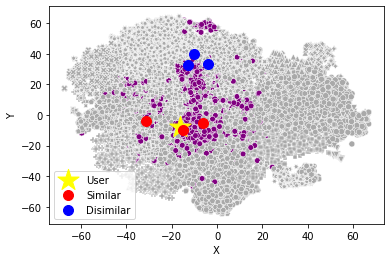

In [20]:
metrics = ['cityblock', 'euclidean', 'cosine']
similars = [('Similar', True), ('Disimilar', False)]
user_recommended_playlists = {}

for similar in similars:
    user_recommended_playlists[similar[0]] = {}
    for metric in metrics:
        user_recommended_playlists[similar[0]][metric] = get_top_n_playlists(model, feats_df, playlists, 
                                                                             scaled_y, 1, metric, similar[1], False)
        


similar_playlists = [user_recommended_playlists['Similar'][key][0] for key in user_recommended_playlists['Similar'].keys()]
disimilar_playlists = [user_recommended_playlists['Disimilar'][key][0] for key in user_recommended_playlists['Disimilar'].keys()]

palette = {c:'purple' if c==user_cluster else 'darkgrey' for c in df.cluster.unique()}
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None, palette=palette)
plt.scatter(x=user_tsne[0], y=user_tsne[1], color='yellow', marker='*', s=500, label='User')
plt.scatter(x='X', y='Y', data=df_opentsne.loc[similar_playlists], color='red', marker='o', s=100, label='Similar')
plt.scatter(x='X', y='Y', data=df_opentsne.loc[disimilar_playlists], color='blue', marker='o', s=100, label='Disimilar')
plt.legend()
plt.show()

In [196]:
def get_songs_recommendations(similar_playlists_indices, n, printing):
    """
    This function computes the variance, of each song in the given playlists, to the user's favorite songs (y_scaled)
    Parameters:
        - similar_playlists_indices (np.array)
    """
    playlist_audio_features = []
    for playlist in similar_playlists_indices:
        for song in playlists[playlist]['tracks']:
            playlist_audio_features.append(sp.audio_features(song['track_uri'].split("k:")[1])[0])

    playlist_audio_features_df = pd.DataFrame(playlist_audio_features)
    array_audio_feats = playlist_audio_features_df[feat_cols_user].to_numpy()
    y_vector = np.array(y).reshape(1,-1)
    low_variance_indices = np.sum(np.square((y_vector-array_audio_feats)),axis=1).argsort(axis=None)
    song_uris = playlist_audio_features_df.loc[low_variance_indices]['id']
    song_uris.drop_duplicates(inplace=True)

    if printing:
        for uri in playlist_audio_features_df.loc[low_variance_indices]['id'][:10]:
            print('Song: {}'.format(sp.track(uri)['name']))
            print('Artist: {}\n'.format(sp.track(uri)['artists'][0]['name']))

    return song_uris[:n]

In [191]:
def build_spotify_playlist(playlist_name, description, items):
    items = items.to_list()
    user_id = sp.current_user()['id']
    new_playlist = sp.user_playlist_create(user_id, playlist_name, description=description)
    sp.playlist_add_items(new_playlist['id'],items=items)


In [215]:
playlist_name = 'KMeans Euclidean Similar 10 playlists'
description = 'Machine Learning playlist'
similar_playlists_indices = get_top_n_playlists(model, feats_df, playlists, scaled_y, 10, 'euclidean', similar=True, printing=False)
song_uris = get_songs_recommendations(similar_playlists_indices,n=30, printing=False)
build_spotify_playlist(playlist_name, description, song_uris)

# Data Modeling and Cluster Exploration with 100,000 sample dataset
### Model and Cluster selection to then scale it to 1M

In [8]:
df_1M = pd.read_csv('data/Playlist_Feats_1M.csv')
df_1M

name     pid  danceability    energy       key  loudness  \
0             Throwbacks       0      0.664077  0.781077  5.038462 -4.891212   
1       Awesome Playlist       1      0.492382  0.695923  4.461538 -8.107974   
2                korean        2      0.671063  0.692953  5.000000 -4.875594   
3                    mat       3      0.514429  0.620902  5.103175 -9.618754   
4                    90s       4      0.576235  0.650418  3.352941 -7.634529   
...                  ...     ...           ...       ...       ...       ...   
999995            Praise  999995      0.500344  0.648406  5.500000 -6.406250   
999996           Worship  999996      0.489115  0.767648  5.385246 -5.726443   
999997               Sex  999997      0.710500  0.572792  5.625000 -7.838292   
999998                ✝️  999998      0.444091  0.613545  5.181818 -6.014182   
999999             BANDA  999999      0.710973  0.653973  5.018182 -5.037764   

            mode  speechiness  acousticness  instrumentalness  liveness  \
0       0.692308     0.103698      0.083674          0.000674  0.187087   
1       0.538462     0.091010      0.162227          0.223708  0.179344   
2       0.515625     0.096425      0.269100          0.000638  0.168894   
3       0.714286     0.067000      0.273514          0.203156  0.188278   
4       0.823529     0.041218      0.177189          0.081759  0.166524   
...          ...          ...           ...               ...       ...   
999995  0.906250     0.039366      0.189567          0.000492  0.125594   
999996  0.745902     0.053704      0.066789          0.005005  0.210858   
999997  0.458333     0.095779      0.345483          0.001642  0.150892   
999998  0.909091     0.040500      0.284768          0.000247  0.156418   
999999  0.781818     0.061299      0.465298          0.006583  0.156296   

         valence       tempo    duration_ms  time_signature  
0       0.642750  121.157500  221777.461538        4.000000  
1       0.476667  124.987128  298837.641026        3.769231  
2       0.565078  114.595984  219373.953125        4.000000  
3       0.451258  125.547627  229575.055556        3.952381  
4       0.490294  127.725412  255014.352941        3.941176  
...          ...         ...            ...             ...  
999995  0.362384  124.214562  265669.562500        3.906250  
999996  0.410438  127.900770  256118.032787        3.942623  
999997  0.571333  120.155125  250632.000000        3.958333  
999998  0.254091  119.226364  264506.818182        3.818182  
999999  0.872427  127.660218  176830.909091        3.309091  

[1000000 rows x 15 columns]

In [9]:
df = df_1M.sample(frac=.1, random_state=0)
df

name     pid  danceability    energy       key   loudness  \
157105  #boostyourrun   24105      0.705381  0.778048  5.952381  -6.125667   
374554     Showtunes   435554      0.531817  0.462325  4.875000  -9.372067   
688694      Christmas  718694      0.468906  0.371871  4.837607 -11.478496   
265381        classic  337381      0.511379  0.793600  5.200000  -7.823157   
955415           jams  959415      0.536200  0.670480  4.640000  -8.236080   
...               ...     ...           ...       ...       ...        ...   
838426            Bus  853426      0.750583  0.594875  4.583333  -7.292125   
735384   Classic Rock  760384      0.509154  0.703923  5.846154  -8.485115   
904801            RUN  912801      0.532667  0.917533  6.533333  -3.851133   
633293          Aspen  669293      0.707148  0.752926  4.444444  -4.946926   
871744    Summer Jamz  883744      0.562082  0.702426  5.622951  -5.512541   

            mode  speechiness  acousticness  instrumentalness  liveness  \
157105  0.571429     0.104705      0.094150          0.059230  0.289824   
374554  0.785714     0.121640      0.494975          0.005648  0.186091   
688694  0.811966     0.043804      0.617678          0.082761  0.151332   
265381  0.692857     0.058678      0.082523          0.071841  0.215549   
955415  0.920000     0.046616      0.205493          0.187808  0.158316   
...          ...          ...           ...               ...       ...   
838426  0.583333     0.169021      0.132299          0.000144  0.223658   
735384  0.730769     0.056031      0.195124          0.037026  0.147619   
904801  0.600000     0.089120      0.008072          0.037202  0.182140   
633293  0.851852     0.164874      0.134062          0.012988  0.230715   
871744  0.852459     0.040330      0.164579          0.001482  0.153982   

         valence       tempo    duration_ms  time_signature  
157105  0.631976  120.015762  226763.523810        3.857143  
374554  0.455032  117.088768  215939.803571        3.875000  
688694  0.359672  118.322137  206815.452991        3.717949  
265381  0.557957  120.936664  270221.614286        3.978571  
955415  0.514872  126.838640  256688.240000        3.880000  
...          ...         ...            ...             ...  
838426  0.388079  127.243500  231973.125000        3.916667  
735384  0.554923  123.260962  291187.269231        4.000000  
904801  0.565400  123.293333  230173.266667        3.933333  
633293  0.570185  118.878111  245943.703704        3.925926  
871744  0.497877  129.695426  213453.540984        3.934426  

[100000 rows x 15 columns]

In [ ]:

scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])
print('Scaler Trained')
feats_df = pd.DataFrame(scaled_data)
feats_df


# Save model and scaled_data locally
filename = 'models/StdScaler_{}.sav'.format(len(df))
pickle.dump(scaler, open(filename, 'wb'))
np.savetxt('data/scaled_data_{}.csv'.format(len(df)), scaled_data, delimiter=',')
print('Scaler and scaled data saved in folder data as StdScaler_1M.sav and scaled_data_1M.csv')

print('Starting TSNE Computation')
# Getting TSNE with openTSNE
tsne = openTSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=-1,
    random_state=0,
    verbose=False,
)

tsne_transformer = tsne.fit(scaled_data)
df_opentsne = pd.DataFrame(tsne_transformer.transform(scaled_data),columns=['X','Y']) 

# Save model locally
filename = 'models/openTSNETransformer_{}.sav'.format(len(df))
pickle.dump(tsne_transformer, open(filename, 'wb'))
df_opentsne.to_csv('data/df_openTSNE_{}.csv'.format(len(df)), index=False)

df_opentsne
sns.scatterplot(x='X', y='Y', data=df_opentsne, legend=None)
print('TSNE Trained and saved locally as openTSNETransformer_{}.sav'.format(len(df)))


#TRAINING MODELS
print('Starting training')
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(date.today().strftime("%B %d, %Y"))
print("Start Time =", current_time)

def model_evaluation(data, max_k=5):
    """
    The models for this function are those models where there is a K number of cluster declaration such as KMeans, Birch,
    AgglomerativeCluster, etc.
    
    This function fits the input models to the input data.
    
    Silhouette, Davies-Bouldin and Calinski-Harabasz are calculated and output to a dictionary
    
    Parameters:
        - models (list): a list of tuples where each tuple is of the form ('model', model).
        - data (df): a dataframe with the scaled data.
        - max_5 (int): max number of k clusters to run for each model.
    Return:
        - dict_scores (dictionary): a dictionary with the scores processed.
    """
    models = [('KMeans', KMeans), ('Birch', Birch), ('Agglomerative', AgglomerativeClustering), 
              ('GaussianMixture', GaussianMixture)]
    
    cluster_size = range(2, max_k+1)
    dict_scores = {}
    dict_scores_partial = {}
    progress = []
    
    #Plot setup
    cols = 3
    rows = len(models)
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    
    for idx, model in enumerate(tqdm(models)):
        silhouette = []
        davies = []
        calinski = []
        print(model[0])
        
        for k in tqdm(cluster_size):
            if model[0] in ('KMeans', 'SpectralClustering'):
                clstr = model[1](n_clusters=k, random_state=0).fit(data)
                labels = clstr.labels_
                
            elif model[0] in ('Agglomerative', 'Birch'):
                clstr = model[1](n_clusters=k).fit(data)
                labels = clstr.labels_
                
            elif model[0]=='GaussianMixture':
                clstr = model[1](n_components=k).fit(data)
                labels = clstr.predict(data)
   
            silhouette.append(silhouette_score(data, labels))
            davies.append(davies_bouldin_score(data, labels))
            calinski.append(calinski_harabasz_score(data, labels))
            
            #Saving locally for large train models
            dict_scores_partial[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
            with open('data/models_with_k_scores_{}_partial.json'.format(len(df)), 'w') as outfile:
                json.dump(dict_scores_partial, outfile, indent=2)
            
            progress.append('Model: {}     Iteration: {}     Seconds per iteration: {}'.format(model[0], k, t2-t1))
            with open("data/progress", "w") as outfile:
                outfile.write("\n".join(progress))
            
        dict_scores[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
                   
        #Plot printing, each model in a row        
        i = 0
        j = idx
        plt.subplot(gs[j,i])
        plt.plot(cluster_size, silhouette, label='silhouette')
        plt.title(model[0]+' - Silhouette', fontsize=15)
        plt.xlabel("K", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        
        plt.subplot(gs[j,i+1])
        plt.plot(cluster_size, davies, label='davies')
        plt.title(model[0]+' - Davies-Bouldin', fontsize=15)
        plt.xlabel("K", fontsize=12)
        
        plt.subplot(gs[j,i+2])
        plt.plot(cluster_size, calinski, label='calinski')
        plt.title(model[0]+' - Calinski-Harabasz', fontsize=15)
        plt.xlabel("K", fontsize=12)
    
    with open('data/models_with_k_scores_{}.json'.format(len(df)), 'w') as outfile:
        json.dump(dict_scores, outfile, indent=2)
    
    plt.tight_layout()
    plt.savefig("images/ClusteringScores_{}.svg".format(df(len)))
    plt.show()
            
    return dict_scores

model_evaluation(feats_df, max_k = 100)

print('Training done')

December 08, 2021
Start Time = 18:05:47
Scaler Trained
Scaler and scaled data saved in folder data as StdScaler_1M.sav and scaled_data_1M.csv
Training time: 1.6449477672576904
Total elapsed time: 1.6451606750488281
Starting TSNE Computation
TSNE Trained and saved locally as openTSNETransformer_100000.sav
Training time: 112.62129831314087
Total elapsed time: 114.26674675941467
Starting training
December 08, 2021
Start Time = 18:07:42



  0%|          | 0/4 [00:00<?, ?it/s]

KMeans



 24%|██▍       | 24/99 [3:14:28<10:06:08, 484.92s/it]

In [3]:
with open("data/models_with_k_scores_100000.json", "r") as read_file:
    scores_dict = json.load(read_file)

models = [*scores_dict]
cluster_size = range(2, 100+1)

#Plot setup
cols = 3
rows = len(models)
y_size = 5*rows
fig = plt.figure(figsize=(18,y_size))
gs = plt.GridSpec(rows, cols)

for idx, model in enumerate(models):
    #Plot printing, each model in a row        
    i = 0
    j = idx
    plt.subplot(gs[j,i])
    plt.plot(cluster_size, scores_dict[model]['silhouette'], label='silhouette')
    plt.title(model+' - Silhouette', fontsize=15)
    plt.xlabel("K", fontsize=12)
    plt.ylabel("Score", fontsize=12)

    plt.subplot(gs[j,i+1])
    plt.plot(cluster_size, scores_dict[model]['davies'], label='davies')
    plt.title(model+' - Davies-Bouldin', fontsize=15)
    plt.xlabel("K", fontsize=12)

    plt.subplot(gs[j,i+2])
    plt.plot(cluster_size, scores_dict[model]['calinski'], label='calinski')
    plt.title(model+' - Calinski-Harabasz', fontsize=15)
    plt.xlabel("K", fontsize=12)

plt.tight_layout()
plt.savefig("images/ClusteringScores_100000.svg")
plt.show()

In [4]:
KMeans_s = np.sort(np.asarray(scores_dict['KMeans']['davies']))[1]
Birch_s = np.sort(np.asarray(scores_dict['Birch']['davies']))[1]
Agglo_s = np.sort(np.asarray(scores_dict['Agglomerative']['davies']))[1]
GM_s = np.sort(np.asarray(scores_dict['GaussianMixture']['davies']))[1]
round(KMeans_s, 2), round(Birch_s, 2), round(Agglo_s, 2), round(GM_s, 2)

(1.54, 1.47, 1.7, 3.07)

In [14]:
# Load scores from model_evaluation() function and extract the best K for each model based on Davies-Bouldin Score.
with open("data/models_with_k_scores_100000.json", "r") as read_file:
    scores_dict = json.load(read_file)

# Extract lower Davies-Bouldin score for each model
KMeans_K = [np.asarray(scores_dict['KMeans']['davies']).argsort()[1]+2]
Birch_K = (np.asarray(scores_dict['Birch']['davies']).argsort()[1:3]+2).tolist()
Aglo_K = [np.asarray(scores_dict['Agglomerative']['davies']).argsort()[1]+2]
GausM_K = [np.asarray(scores_dict['GaussianMixture']['davies']).argsort()[1]+2]

models = [('KMeans', KMeans, KMeans_K), ('Birch', Birch, Birch_K), ('Agglomerative', AgglomerativeClustering, Aglo_K), 
          ('GaussianMixture', GaussianMixture, GausM_K)]

#Plot setup
cols = 2
rows = len(models)
y_size = 5*rows
fig = plt.figure(figsize=(12,y_size))
gs = plt.GridSpec(rows, cols)


# Fit and plot with best K
for idx, model in enumerate(models):
    i=0
    for k in model[2]:
        if model[0] in ('KMeans'):
            clstr = model[1](n_clusters=k, random_state=0).fit(feats_df)
            labels = clstr.labels_
                
        elif model[0] in ('Agglomerative', 'Birch'):
            clstr = model[1](n_clusters=k).fit(feats_df)
            labels = clstr.labels_
                
        elif model[0]=='GaussianMixture':
            clstr = model[1](n_components=k).fit(feats_df)
            labels = clstr.predict(feats_df)
        
        
        #Plot printing, each model in a row        
        
        j = idx
        plt.subplot(gs[j,i])
        plt.title(model[0]+' - K={}'.format(k), fontsize=15)
        
        df_opentsne['cluster'] = pd.Categorical(labels)
        sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
        
        i+=1
plt.tight_layout()
plt.savefig("images/ClusteringOnTSNE_100000.svg")
plt.show()    

In [12]:
scaler_path = 'models/StdScaler_100000.sav'
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

scaler = pickle.load(open(scaler_path, 'rb'))
scaled_data = scaler.transform(df[feat_cols_user])

feats_df = pd.DataFrame(scaled_data)
feats_df

0         1         2         3         4         5         6   \
0      1.027434  1.071605  1.156817  0.506413 -0.536595  0.197850 -0.847087   
1     -0.761913 -1.308730 -0.442987 -0.790800  0.845081  0.496678  1.441224   
2     -1.410490 -1.990697 -0.498512 -1.632497  1.014346 -0.876749  2.141733   
3     -0.972621  1.188860  0.039606 -0.171879  0.246355 -0.614302 -0.913462   
4     -0.716726  0.260617 -0.791939 -0.336877  1.710931 -0.827135 -0.211429   
...         ...       ...       ...       ...       ...       ...       ...   
99995  1.493445 -0.309395 -0.876083  0.040314 -0.459835  1.332717 -0.629294   
99996 -0.995557  0.512755  0.999081 -0.436387  0.490805 -0.661010 -0.270624   
99997 -0.753153  2.123234  2.019474  1.415283 -0.352371 -0.077145 -1.338504   
99998  1.045653  0.882204 -1.082319  0.977420  1.271524  1.259547 -0.619229   
99999 -0.449898  0.501470  0.667646  0.751409  1.275439 -0.938061 -0.445007   

             7         8         9         10        11        12  
0     -0.031118  2.381495  1.114963 -0.153574 -0.205649 -0.835833  
1     -0.443168 -0.033288 -0.263931 -0.546008 -0.470556 -0.658746  
2      0.149834 -0.842416 -1.007053 -0.380645 -0.693872 -2.216208  
3      0.065858  0.652457  0.538147 -0.030105  0.857973  0.368362  
4      0.957662 -0.679848  0.202393  0.761198  0.526748 -0.609161  
...         ...       ...       ...       ...       ...       ...  
99995 -0.485494  0.841243 -0.785680  0.815479 -0.078146 -0.245542  
99996 -0.201868 -0.928856  0.514503  0.281523  1.371100  0.580867  
99997 -0.200515 -0.125254  0.596148  0.285864 -0.122197 -0.080260  
99998 -0.386723  1.005509  0.633438 -0.306103  0.263779 -0.153719  
99999 -0.475210 -0.780739  0.069954  1.144219 -0.531407 -0.069422  

[100000 rows x 13 columns]

In [17]:
df

name     pid  danceability    energy       key   loudness  \
157105  #boostyourrun   24105      0.705381  0.778048  5.952381  -6.125667   
374554     showtunes   435554      0.531817  0.462325  4.875000  -9.372067   
688694      christmas  718694      0.468906  0.371871  4.837607 -11.478496   
265381        classic  337381      0.511379  0.793600  5.200000  -7.823157   
955415           jams  959415      0.536200  0.670480  4.640000  -8.236080   
...               ...     ...           ...       ...       ...        ...   
838426            bus  853426      0.750583  0.594875  4.583333  -7.292125   
735384   classic rock  760384      0.509154  0.703923  5.846154  -8.485115   
904801            run  912801      0.532667  0.917533  6.533333  -3.851133   
633293          aspen  669293      0.707148  0.752926  4.444444  -4.946926   
871744    summer jamz  883744      0.562082  0.702426  5.622951  -5.512541   

            mode  speechiness  acousticness  instrumentalness  liveness  \
157105  0.571429     0.104705      0.094150          0.059230  0.289824   
374554  0.785714     0.121640      0.494975          0.005648  0.186091   
688694  0.811966     0.043804      0.617678          0.082761  0.151332   
265381  0.692857     0.058678      0.082523          0.071841  0.215549   
955415  0.920000     0.046616      0.205493          0.187808  0.158316   
...          ...          ...           ...               ...       ...   
838426  0.583333     0.169021      0.132299          0.000144  0.223658   
735384  0.730769     0.056031      0.195124          0.037026  0.147619   
904801  0.600000     0.089120      0.008072          0.037202  0.182140   
633293  0.851852     0.164874      0.134062          0.012988  0.230715   
871744  0.852459     0.040330      0.164579          0.001482  0.153982   

         valence       tempo    duration_ms  time_signature cluster  
157105  0.631976  120.015762  226763.523810        3.857143      14  
374554  0.455032  117.088768  215939.803571        3.875000       1  
688694  0.359672  118.322137  206815.452991        3.717949      10  
265381  0.557957  120.936664  270221.614286        3.978571       7  
955415  0.514872  126.838640  256688.240000        3.880000       7  
...          ...         ...            ...             ...     ...  
838426  0.388079  127.243500  231973.125000        3.916667       2  
735384  0.554923  123.260962  291187.269231        4.000000       7  
904801  0.565400  123.293333  230173.266667        3.933333      15  
633293  0.570185  118.878111  245943.703704        3.925926       4  
871744  0.497877  129.695426  213453.540984        3.934426       7  

[100000 rows x 16 columns]

In [28]:
# # Fit and pickle model. Uncomment to retrain
filename = 'models/KMeans_K17_{}_sample_model.sav'.format(len(df))
model = KMeans(n_clusters=17, random_state=0).fit(feats_df)
pickle.dump(model, open(filename, 'wb'))
top_playlists = []
df_cluster = pd.DataFrame()

def cluster_exploration(model, df):
    df['name'] = df['name'].str.lower()
    df['cluster'] = pd.Categorical(model.labels_)
    categories = df['cluster'].cat.categories
    
    #Plot setup
    cols = 5
    rows = len(categories)//cols + len(categories)%cols
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    sequential =['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
             'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    
    for idx, category in enumerate(categories):
        color = random.choice(sequential)
        df_cat = df[df['cluster']==category]
        df_cat["name"].fillna("", inplace=True)
        text = ' '.join(df_cat["name"])
        df_cat = (df_cat.groupby('name')
                             .agg(count=('pid', 'count'))
                             .reset_index().sort_values(by=['count'], ascending=False)
                             .head(10)
                             .reset_index(drop=True))
        df_cat.rename({'name': 'Cluster {}'.format(category)}, axis=1, inplace=True)
        top_playlists.append(df_cat[['Cluster {}'.format(category)]])

        #Plot printing, each model in a row        
        i = idx%cols
        j = idx//cols
        plt.subplot(gs[j,i])
        wc = WordCloud(background_color ='white',relative_scaling=0, width=500, height=500, colormap=color).generate(text)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title('Playlists Cluster: {}'.format(category), size=20)
    plt.tight_layout()
    plt.savefig("images/WordCloudPerCluster.svg")
    plt.show()  
    return pd.concat(top_playlists, axis=1)
top_playlists_df = cluster_exploration(model, df)

In [55]:
top_playlists_df

Cluster 0  Cluster 1 Cluster 2     Cluster 3  Cluster 4  \
0              oldies      chill       rap          jazz        pop   
1            classics      feels       lit         study     summer   
2        classic rock      sleep     party  instrumental    workout   
3  oldies but goodies        sad   workout         sleep      chill   
4                 80s       love      hype          yoga       jams   
5           christmas    worship   turn up         chill      party   
6                80's     mellow     litty        mellow  throwback   
7             classic      relax      trap         relax        new   
8          old school    wedding     chill     classical       2017   
9             wedding  christmas      jams         jazzy    running   

       Cluster 5  Cluster 6     Cluster 7       Cluster 8           Cluster 9  \
0          chill      chill       country             rap             worship   
1          house      vibes          rock         hip hop              gospel   
2            edm        r&b  classic rock         workout           christian   
3     electronic      feels      country       old school              praise   
4        dubstep        new        summer          eminem               jesus   
5         trance        sex   alternative          reggae            worship    
6          beats  slow jams     christian      throwbacks          jesus jams   
7          dance       jams     throwback       throwback  praise and worship   
8  instrumentals       2017           90s           party     christian music   
9         lounge       mood        oldies  old school rap              prayer   

        Cluster 10      Cluster 11       Cluster 12       Cluster 13  \
0        christmas           sleep        classical           comedy   
1           disney           books     instrumental          stories   
2           oldies     white noise            piano          comedy    
3            sleep      devotional            study  bedtime stories   
4            chill        dj music            sleep            funny   
5         musicals           drive      soundtracks         learning   
6         acoustic     mindfulness      study music            sagor   
7       christmas   nature sounds          studying            sleep   
8  christmas music           noise  classical music      spoken word   
9              sad           quran     harry potter         stand up   

   Cluster 14 Cluster 15 Cluster 16  
0   throwback       rock      banda  
1  throwbacks        edm   corridos  
2       party    workout    spanish  
3     workout    dubstep     banda   
4      reggae      metal    mexican  
5     spanish        gym  christmas  
6       dance    running   norteñas  
7     running        run   spanish   
8   reggaeton       punk  corridos   
9         pop   work out         🇲🇽

In [17]:
# Change the path to where your Spotify Million Playlist is located.
# The expected file structure is to have a data folder /data .csv files will be placed there.
# Look for Playlist in the 100,000 sample dataset

path = 'data/spotify_million_playlist_dataset/data'
PIDs = df['pid'].tolist()

def loop_slices(path, num_slices=20):
    """
    Each slice is a .json file containing 1000 playlists i.e.: 1 slice is 1000 playlists 20 slices is: 20,000 playlists.
    Parameters:
        num_slices (int): Number of slices to return, max 1000.
        path (str): Path to the Spotify Million Playlist.
        
    Output:
        mpd_playlists (list): a list of dictionaries of all the playlists.
    """
    cnt=0
    mpd_playlists = []
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        cnt+=1
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)
            
            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                if playlist['pid'] in PIDs:
                    mpd_playlists.append(playlist)


            if cnt == num_slices:
                break
    return mpd_playlists

In [18]:
playlists = loop_slices(path, 1000)

mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json
mpd.slice.116000-116999.json
mpd.slice.117000-117999.json
mpd.slice.118000-118999.json
mpd.slice.119000-119999.json
mpd.slice.12000-12999.json
mpd.slice.120000-120999.json
mpd.slice.121000-121999.json
mpd.slice.122000-122999.json
mpd.slice.123000-123999.json
mpd.slice.124000-124999.json
mpd.slice.125000-125999.json
mpd.slice.126000-126999.json
mpd.slice.127000-127999.json
mpd.slice.128000-128999.json
mpd.slice.129000-129999.json
mpd

In [20]:
with open('data/playlists_{}.json'.format(len(df)), 'w') as outfile:
    json.dump(playlists, outfile, indent=2)

# Once Model has been selected train model with 1M Samples (Full Dataset)

In [25]:
df = pd.read_csv('data/Playlist_Feats_1M.csv')
df = df.sample(frac=.001, random_state=0)
df

name     pid  danceability    energy       key   loudness  \
157105  #boostyourrun   24105      0.705381  0.778048  5.952381  -6.125667   
374554     Showtunes   435554      0.531817  0.462325  4.875000  -9.372067   
688694      Christmas  718694      0.468906  0.371871  4.837607 -11.478496   
265381        classic  337381      0.511379  0.793600  5.200000  -7.823157   
955415           jams  959415      0.536200  0.670480  4.640000  -8.236080   
...               ...     ...           ...       ...       ...        ...   
437812    Summer 2017  492812      0.623765  0.706471  4.764706  -5.751882   
839409           hype  854409      0.728590  0.639949  4.871795  -5.923000   
946579        Variety  950579      0.561057  0.518318  5.733333  -9.024267   
155540             II  238540      0.568063  0.689313  5.093750  -7.156969   
267387        Chill 2  339387      0.655267  0.637267  6.133333  -6.366733   

            mode  speechiness  acousticness  instrumentalness  liveness  \
157105  0.571429     0.104705      0.094150          0.059230  0.289824   
374554  0.785714     0.121640      0.494975          0.005648  0.186091   
688694  0.811966     0.043804      0.617678          0.082761  0.151332   
265381  0.692857     0.058678      0.082523          0.071841  0.215549   
955415  0.920000     0.046616      0.205493          0.187808  0.158316   
...          ...          ...           ...               ...       ...   
437812  0.529412     0.081947      0.106098          0.006153  0.125235   
839409  0.666667     0.119131      0.130817          0.000114  0.179815   
946579  0.633333     0.067758      0.357632          0.044944  0.173272   
155540  0.562500     0.063247      0.211440          0.278529  0.221619   
267387  0.800000     0.040687      0.282327          0.000010  0.131947   

         valence       tempo    duration_ms  time_signature  
157105  0.631976  120.015762  226763.523810        3.857143  
374554  0.455032  117.088768  215939.803571        3.875000  
688694  0.359672  118.322137  206815.452991        3.717949  
265381  0.557957  120.936664  270221.614286        3.978571  
955415  0.514872  126.838640  256688.240000        3.880000  
...          ...         ...            ...             ...  
437812  0.590000  114.960765  216541.705882        4.000000  
839409  0.551692  123.747615  223385.076923        4.000000  
946579  0.441757  114.408817  259862.866667        3.966667  
155540  0.393991  120.246188  271249.343750        3.968750  
267387  0.664867  118.743600  224270.800000        4.000000  

[1000 rows x 15 columns]

Starting TSNE Computation


<AxesSubplot:xlabel='X', ylabel='Y'>

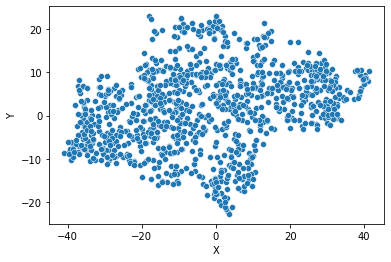

In [26]:
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])
feats_df = pd.DataFrame(scaled_data)


# Save model and scaled_data locally
filename = 'models/StdScaler_{}.sav'.format(len(df))
pickle.dump(scaler, open(filename, 'wb'))
np.savetxt('data/scaled_data_{}.csv'.format(len(df)), scaled_data, delimiter=',')

print('Starting TSNE Computation')
# Getting TSNE with openTSNE
tsne = openTSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=-1,
    random_state=0,
    verbose=False,
)

tsne_transformer = tsne.fit(scaled_data)
df_opentsne = pd.DataFrame(tsne_transformer.transform(scaled_data),columns=['X','Y']) 

# Save model locally
filename = 'models/openTSNETransformer_{}.sav'.format(len(df))
pickle.dump(tsne_transformer, open(filename, 'wb'))
df_opentsne.to_csv('data/df_openTSNE_{}.csv'.format(len(df)), index=False)

sns.scatterplot(x='X', y='Y', data=df_opentsne, legend=None)

In [31]:
# Fit and pickle model. Uncomment to retrain
filename = 'models/KMeans_K17_{}_sample_model.sav'.format(len(df))
model = KMeans(n_clusters=17, random_state=0).fit(feats_df)
pickle.dump(model, open(filename, 'wb'))

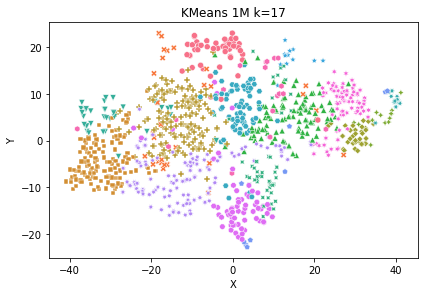

In [34]:
labels = model.labels_
                
df_opentsne['cluster'] = pd.Categorical(labels)
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_opentsne, legend=None)
plt.tight_layout()
plt.title('KMeans 1M k=17')
plt.savefig("images/ClusteringOnTSNE_{}.svg".format(len(df)))
plt.show()   

/usr/local/lib/python3.9/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


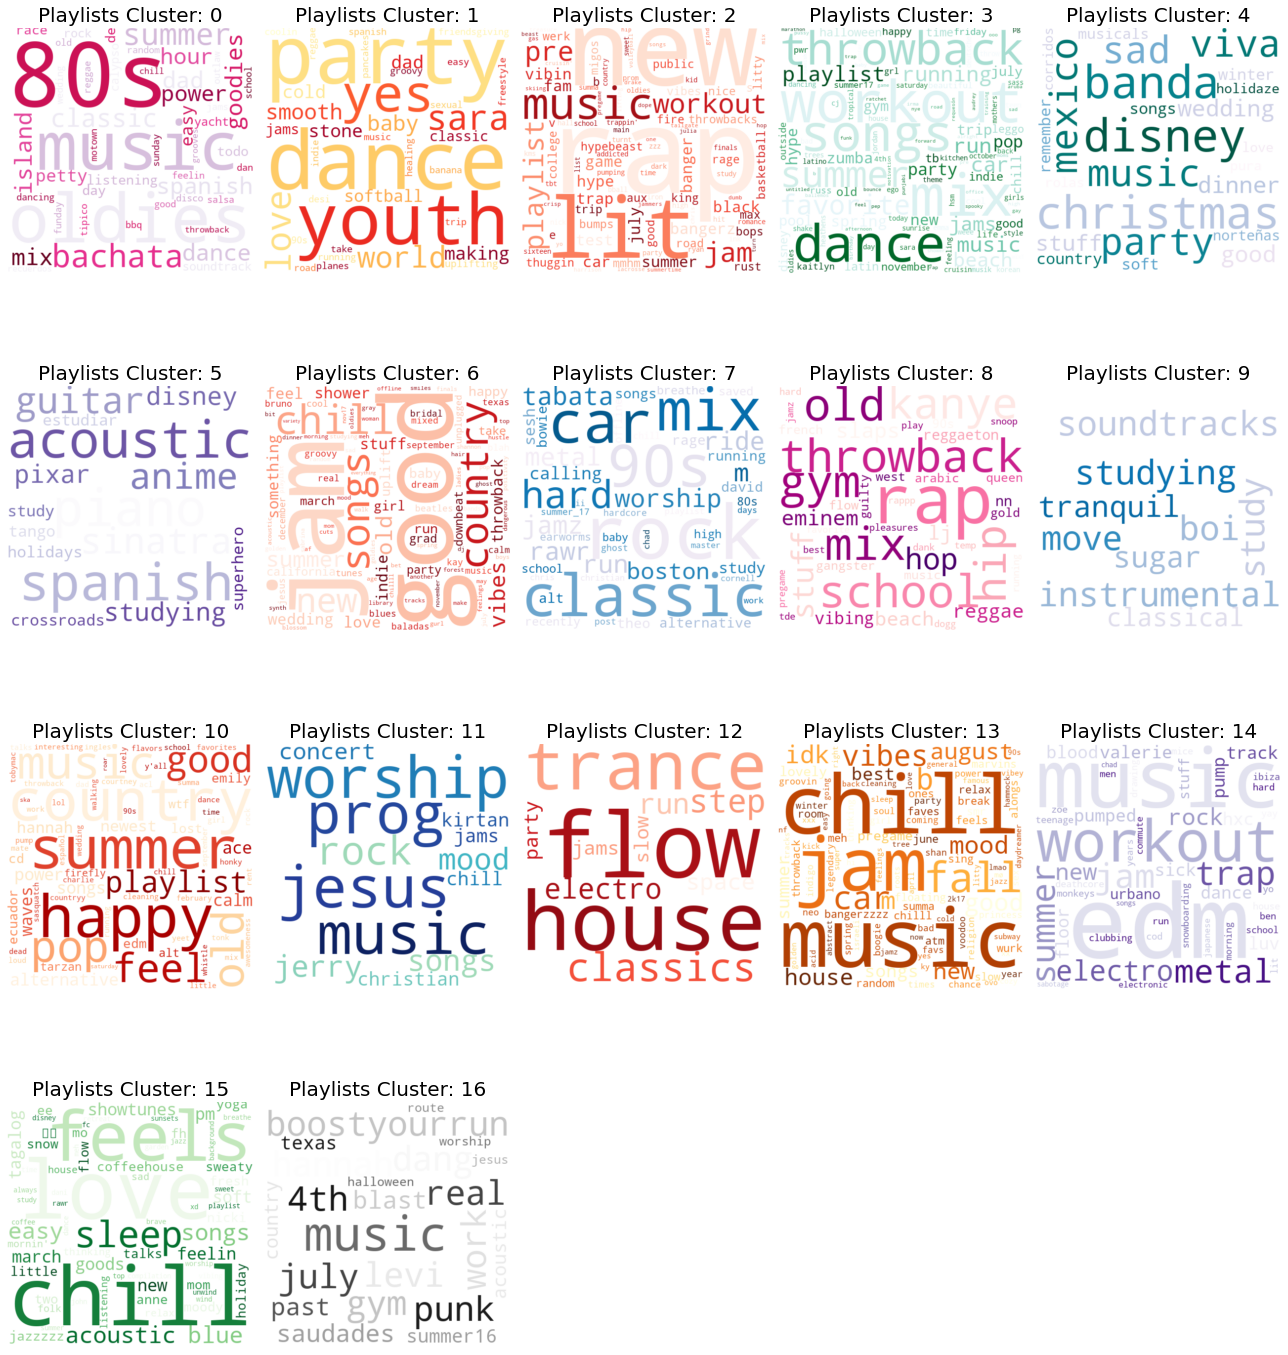

Cluster 0     Cluster 1 Cluster 2          Cluster 3  \
0                 80s   dance party       rap            running   
1             bachata           90s   workout            workout   
2              summer        planes       lit              dance   
3              oldies           yes  pre game        workout mix   
4  oldies but goodies         world       car                 me   
5             spanish     uplifting   new new          throwback   
6                80's  take it easy      hype              beach   
7          summer '17    stone cold    skiing                pop   
8       sunday funday       spanish      ryan                 tb   
9           throwback     softball       rust  my favorite songs   

         Cluster 4        Cluster 5           Cluster 6      Cluster 7  \
0        christmas         acoustic                jams        worship   
1           disney            anime               indie   classic rock   
2  christmas music     crossroads.            feel good      hard rock   
3  christmas party     disney pixar       something new          metal   
4            banda         estudiar            *smiles*           theo   
5         remember         holidays            my songs       the 90's   
6     winter songs            piano  oldies but goldies            mix   
7   wedding dinner          sinatra           old vibes        offline   
8     viva mexico!  spanish guitar          old country           work   
9   the good stuff            study             offline  post-hardcore   

    Cluster 8     Cluster 9  ...      Cluster 7   Cluster 8     Cluster 9  \
0  throwbacks  instrumental  ...        worship  throwbacks  instrumental   
1    90's mix   soundtracks  ...   classic rock    90's mix   soundtracks   
2     running      studying  ...      hard rock     running      studying   
3     pregame           boi  ...          metal     pregame           boi   
4       queen     classical  ...           theo       queen     classical   
5         rap       move it  ...       the 90's         rap       move it   
6   rap stuff         study  ...            mix   rap stuff         study   
7       rappp         sugar  ...        offline       rappp         sugar   
8  reggae mix      tranquil  ...           work  reggae mix      tranquil   
9       slaps           NaN  ...  post-hardcore       slaps           NaN   

      Cluster 10     Cluster 11       Cluster 12   Cluster 13     Cluster 14  \
0        country        worship               34        chill            edm   
1            pop     chill jams    electro house          idk        workout   
2  september '17      christian             flow  august 2016          music   
3      sasquatch        concert      house party          car        electro   
4        running    in the mood              run          sex             00   
5           roar          jerry        slow flow        roots   songs i like   
6           rent    jesus music       space jams    right now  of mice & men   
7        pump up         kirtan            step.      relax 2       pump up    
8          power      prog rock  trance classics      random     rock urbano   
9            edm  worship songs              NaN     princess        rock ��   

    Cluster 15     Cluster 16  
0        chill  #boostyourrun  
1        sleep    4th of july  
2          #mo           work  
3         snow  texas country  
4  sleep songs       summer16  
5   showtunes        saudades  
6          sad       route 66  
7     retreat      real music  
8     rawr xd            punk  
9           pm           levi  

[10 rows x 34 columns]

In [30]:
cluster_exploration(model, df)